# Normal model

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
df = pd.read_csv("her2_all_features.csv")  

# Drop filename and target column
X = df.drop(columns=["tile", "label"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weights_dict)

Class weights: {np.int64(0): np.float64(0.7491548343475322), np.int64(1): np.float64(1.503392130257802)}


# Random Forest

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your combined feature dataset
df = pd.read_csv("her2_all_features.csv")  # or "her2_all_combined_features.csv" if you had all features

# Drop unnecessary columns and split
X = df.drop(columns=["tile", "label"])
y = df["label"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["HER2−", "HER2+"]))


Random Forest Confusion Matrix:
[[869  51]
 [398  67]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.69      0.94      0.79       920
       HER2+       0.57      0.14      0.23       465

    accuracy                           0.68      1385
   macro avg       0.63      0.54      0.51      1385
weighted avg       0.65      0.68      0.61      1385



# Cross validstion

In [35]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Load your features
df = pd.read_csv("her2_all_features.csv")  # or combined CSV if using all features

# Separate X and y
X = df.drop(columns=["tile", "label"])
y = df["label"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

# Create Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred = cross_val_predict(rf, X_scaled, y, cv=skf)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))

print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["HER2−", "HER2+"]))

Confusion Matrix:
[[3485  195]
 [1551  309]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.69      0.95      0.80      3680
       HER2+       0.61      0.17      0.26      1860

    accuracy                           0.68      5540
   macro avg       0.65      0.56      0.53      5540
weighted avg       0.67      0.68      0.62      5540



In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("After SMOTE:", np.bincount(y_resampled))

from sklearn.model_selection import train_test_split

# Original split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, stratify=y, random_state=42
)

# Now apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train RF on resampled training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate on untouched test data
y_pred = rf.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HER2−", "HER2+"]))


After SMOTE: [3680 3680]
Confusion Matrix:
[[804 116]
 [331 134]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.71      0.87      0.78       920
       HER2+       0.54      0.29      0.37       465

    accuracy                           0.68      1385
   macro avg       0.62      0.58      0.58      1385
weighted avg       0.65      0.68      0.65      1385



In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],  # instead of [100, 200, 300]
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}


grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, scoring='f1_macro', n_jobs=1)
grid.fit(X_train_resampled, y_train_resampled)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["HER2−", "HER2+"]))


              precision    recall  f1-score   support

       HER2−       0.71      0.87      0.78       920
       HER2+       0.54      0.29      0.37       465

    accuracy                           0.68      1385
   macro avg       0.62      0.58      0.58      1385
weighted avg       0.65      0.68      0.65      1385



# Feature Selection

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 1000 features
selector = SelectKBest(score_func=f_classif, k=1000)
X_selected = selector.fit_transform(X_scaled, y)

print("Selected shape:", X_selected.shape)

Selected shape: (5540, 1000)


In [41]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, stratify=y, random_state=42
)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Evaluate
y_pred = rf.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HER2−", "HER2+"]))


Confusion Matrix:
[[770 150]
 [302 163]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.72      0.84      0.77       920
       HER2+       0.52      0.35      0.42       465

    accuracy                           0.67      1385
   macro avg       0.62      0.59      0.60      1385
weighted avg       0.65      0.67      0.65      1385



In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Keep same resampled data from previous setup
rf = RandomForestClassifier(
    n_estimators=300,            # slightly more trees
    max_depth=None,              # allow deep trees
    max_features='sqrt',         # random subset of features per split
    min_samples_leaf=2,          # reduces overfitting on noise
    random_state=42
)

rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HER2−", "HER2+"]))

Confusion Matrix:
[[788 132]
 [299 166]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.72      0.86      0.79       920
       HER2+       0.56      0.36      0.44       465

    accuracy                           0.69      1385
   macro avg       0.64      0.61      0.61      1385
weighted avg       0.67      0.69      0.67      1385



# XGBoost

In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.25, stratify=y, random_state=42
)

# Step 2: Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 3: Final tuned XGBoost
xgb_final = XGBClassifier(
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.015,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=1,
    min_child_weight=3,
    scale_pos_weight=2,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Step 4: Fit and predict
xgb_final.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_final.predict(X_test)


/home/adarsh/Documents/MSLS internship/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:18:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Final Report

Confusion Matrix:
[[795 125]
 [139 326]]

Classification Report:
              precision    recall  f1-score   support

       HER2−       0.85      0.86      0.86       920
       HER2+       0.72      0.70      0.71       465

    accuracy                           0.81      1385
   macro avg       0.79      0.78      0.78      1385
weighted avg       0.81      0.81      0.81      1385



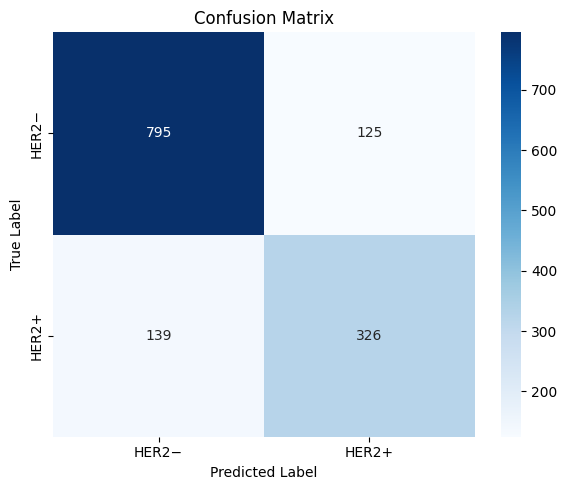

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true = y_test
y_pred = xgb_final.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
labels = ["HER2−", "HER2+"]

print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
